#### Dependencies
____

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import date, datetime
from pylab import rcParams

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

sns.set(style="whitegrid")

#### Load Data
____

In [2]:
dataset = '../resources/daily_household_power_consumption.csv'

master = pd.read_csv(dataset, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

master.tail(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,kitchen_active_energy,laundry_active_energy,water_heater_ac_active_energy,equipment_active_energy
datetime,,,,,,,,
2010-11-22,2041.536,142.354,345883.85,8660.4,4855.0,2110.0,10136.0,16924.600023
2010-11-23,1577.536,137.450,346428.76,6731.2,1871.0,458.0,7611.0,16352.266679
2010-11-24,1796.248,132.460,345644.59,7559.4,1096.0,2848.0,12224.0,13769.466664
2010-11-25,1431.164,116.128,347812.21,6004.0,1076.0,426.0,5072.0,17278.733338
2010-11-26,1488.104,120.826,303487.57,6259.8,1080.0,385.0,9989.0,13347.733336


In [3]:
master.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,kitchen_active_energy,laundry_active_energy,water_heater_ac_active_energy,equipment_active_energy
count,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000
mean,1567.839069,178.004759,346600.529542,6646.587101,1609.656033,1858.135229,9280.574202,13382.285696
std,597.306856,48.881691,7375.850040,2472.108924,1581.726035,2085.161400,3674.915577,6071.784572
min,250.298000,34.922000,93552.530000,1164.000000,0.000000,0.000000,1288.000000,2313.633346
25%,1176.195000,143.063000,345736.802500,5055.400000,700.000000,432.500000,6681.000000,9400.766697
50%,1543.253000,171.199000,346979.430000,6539.300000,1119.000000,696.000000,9272.000000,12634.700023
75%,1894.467500,202.548500,348283.367500,7965.600000,2201.750000,2732.000000,11764.000000,16498.225003
max,4773.386000,417.834000,356306.410000,20200.400000,11178.000000,12109.000000,23743.000000,61736.433386


#### Season feature
_____

In [4]:
def get_season(item):
    
    dt = item.name.timetuple().tm_yday

    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)    
    
    if dt in spring:
        return 'spring'
    
    elif dt in summer:
        return 'summer'
    
    elif dt in fall:
        return 'fall'
    else:
        return 'winter'

#### Data Summary
____

In [5]:
size     = master.shape[0]
features = master.shape[1]
min_date = master.index.min()
max_date = master.index.max()

active_min    = master['Global_active_power'].min()
active_mean   = master['Global_active_power'].mean()
active_median = master['Global_active_power'].median()
active_max    = master['Global_active_power'].max()
active_stddev = master['Global_active_power'].std()

summary_data = [{
    'Records'                  : size,
    'Features'                 : features,
    'From Date'                : min_date, 
    'To Date'                  : max_date,
    'Minimum consume(kwh)'     : active_min,
    'Average consume(kwh)'     : active_mean,
    'Median consume(kwh)'      : active_median,
    'Max consume(kwh)'         : active_max,
    'Standard Deviation(kwh)'  : active_stddev
}]

summary = pd.DataFrame(data=summary_data, columns=list(summary_data[0].keys()))

summary['Minimum consume(kwh)']    = summary['Minimum consume(kwh)'].map('{:.2f}'.format)
summary['Average consume(kwh)']    = summary['Average consume(kwh)'].map('{:.2f}'.format)
summary['Median consume(kwh)']     = summary['Median consume(kwh)'].map('{:.2f}'.format)
summary['Max consume(kwh)']        = summary['Max consume(kwh)'].map('{:.2f}'.format)
summary['Standard Deviation(kwh)'] = summary['Standard Deviation(kwh)'].map('{:.2f}'.format)


summary

,Records,Features,From Date,To Date,Minimum consume(kwh),Average consume(kwh),Median consume(kwh),Max consume(kwh),Standard Deviation(kwh)
0,1442,8,2006-12-16,2010-11-26,250.30,1567.84,1543.25,4773.39,597.31


#### Distribution
##### Global_active_power
____

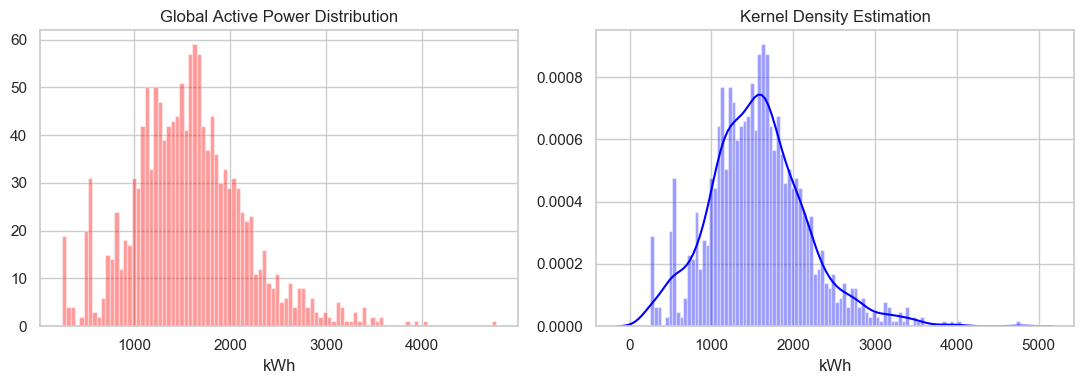

In [6]:
fig, axes =  plt.subplots(nrows=1, ncols=2, figsize=(11,4), dpi=100)

axes[0].set_title('Global Active Power Distribution')
sns.distplot(master['Global_active_power'], ax=axes[0],bins=100, kde=False,color='red', axlabel='kWh')

axes[1].set_title('Kernel Density Estimation')
sns.distplot(master['Global_active_power'], ax=axes[1],bins=100, kde=True,color='blue',axlabel='kWh')

plt.tight_layout()

##### Global_active_power over seasons
____

In [118]:
#data_s = master.copy(deep=True)
#data_s['season'] = data_s.apply(get_season, axis=1)
#data_s.columns

#fig, axes =  plt.subplots(nrows=1, ncols=1, figsize=(9,5), dpi=100)

#sns.boxplot(x='season', y='Global_active_power', data=data_s, ax=axes)
#axes.set_title('Active power Over Seasons')
#axes.set_ylabel('kWh')

#plt.tight_layout()

#### Counts Of Observations Over Time
_____

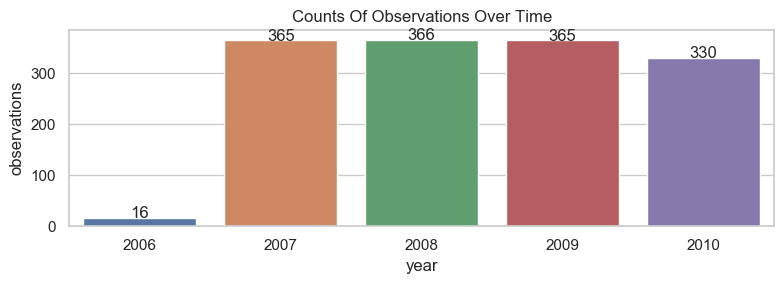

In [7]:
fig, axes =  plt.subplots(nrows=1, ncols=1, figsize=(8,3), dpi=100)

data_c = master.copy(deep=True)
data_c.reset_index(inplace=True)
data_c['year'] = data_c['datetime'].apply(lambda item: item.year)

sns.countplot(x="year", data=data_c, ax=axes)
axes.set_title('Counts Of Observations Over Time')
axes.set_ylabel('observations')


for p in axes.patches:
    axes.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 3), textcoords = 'offset points')


plt.tight_layout()

## Active Power Over Time
_____

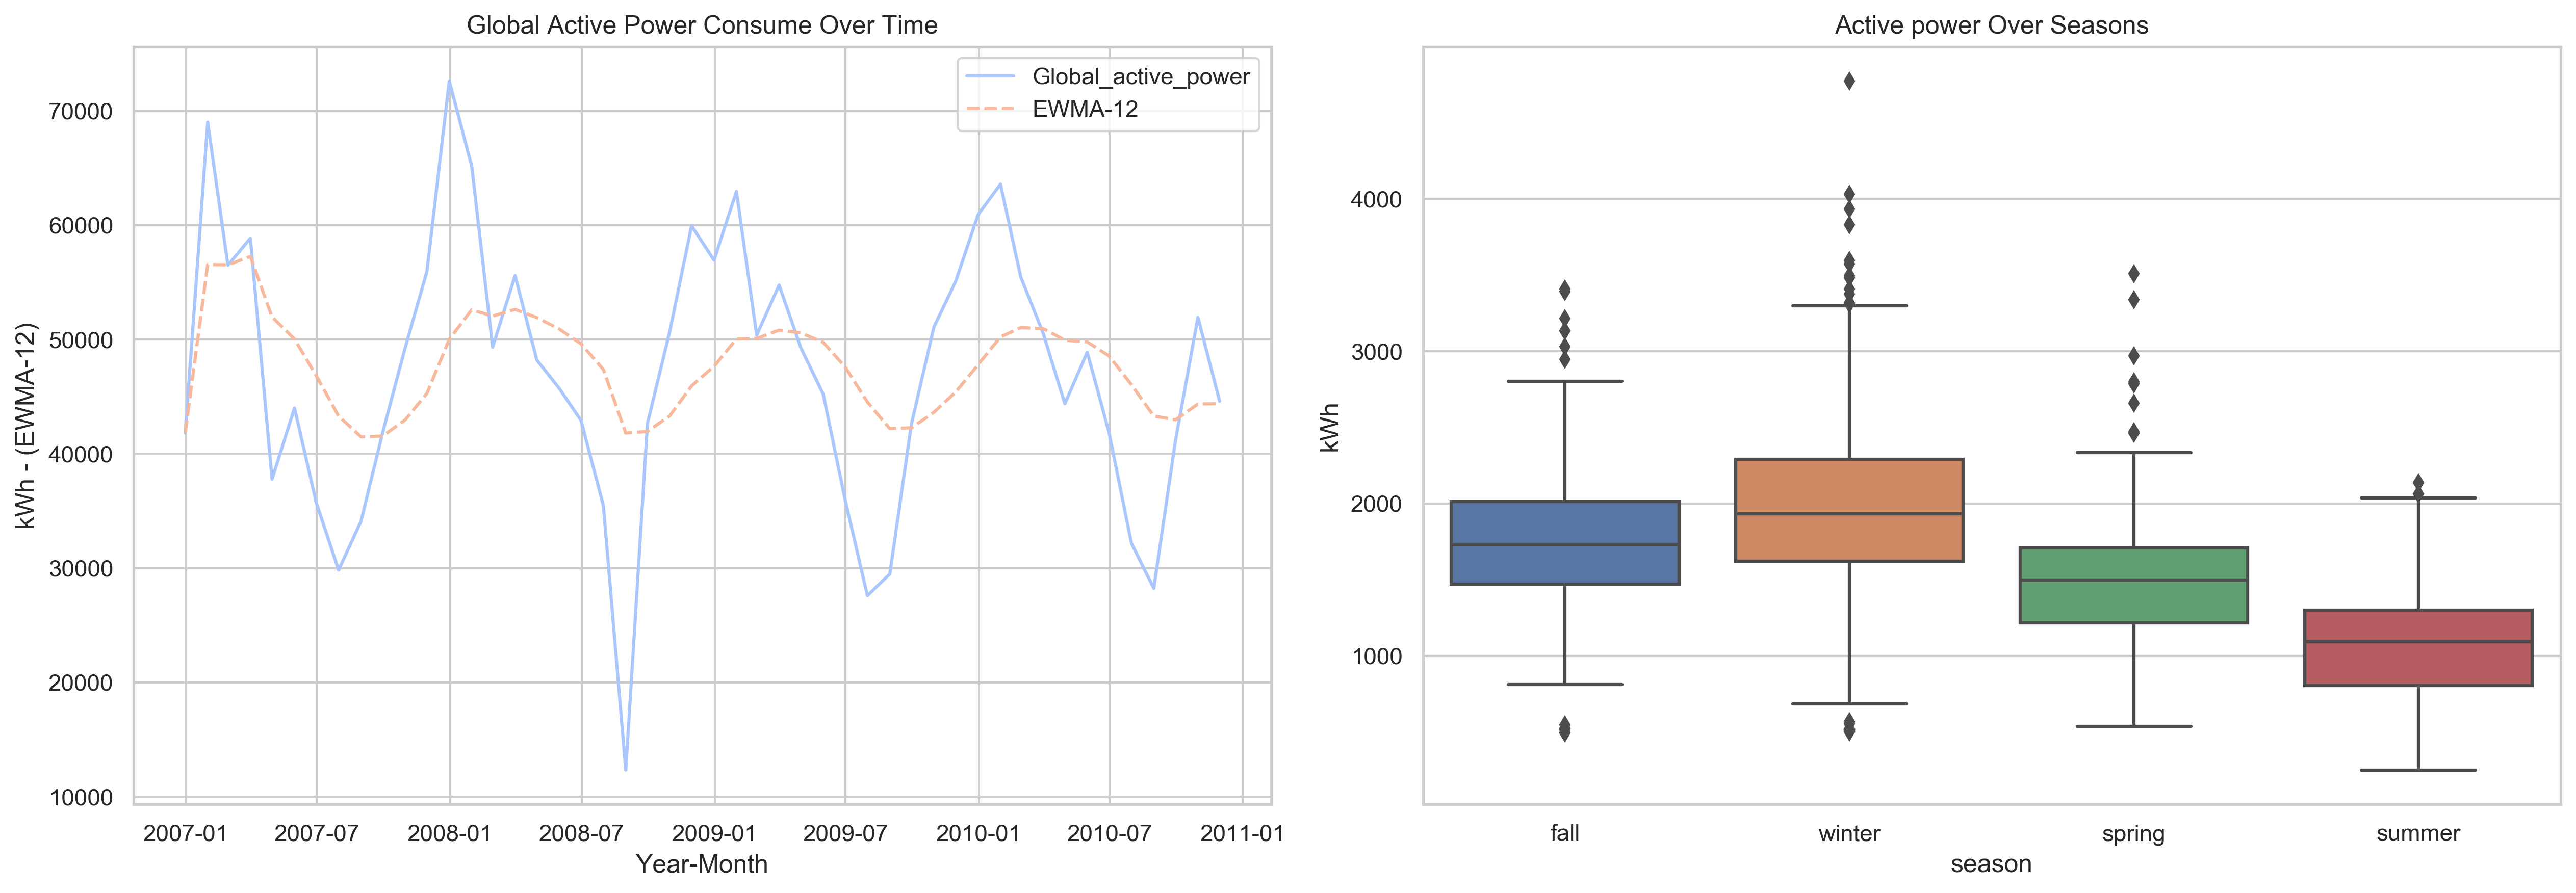

In [8]:
#overall data
#data_m = master.resample('M').sum()['Global_active_power']

data_m = master.resample('M').sum()
data_m['EWMA-12'] = data_m['Global_active_power'].ewm(span=12).mean()
data_m = data_m[['Global_active_power', 'EWMA-12']]

# season data
data_s = master.copy(deep=True)
data_s['season'] = data_s.apply(get_season, axis=1)


#data_s = master.copy(deep=True)
#data_s['season'] = data_s.apply(get_season, axis=1)
#data_s.reset_index(inplace=True)
#data_s['year'] = data_s['datetime'].apply(lambda item: item.year)
#data_season = data_s.groupby(by=['year', 'season'],as_index=False).agg({
#    'Global_active_power' : 'sum'
#}).pivot(index='year', columns='season', values='Global_active_power')

# skip 2006 
#cond = data_season.index > 2006
#data_season[cond]

#data_season.fillna(value=0,inplace=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,6), dpi=300)
sns.lineplot(data=data_m,ax=axes[0],palette='coolwarm')
sns.boxplot(x='season', y='Global_active_power', data=data_s, ax=axes[1])
#sns.heatmap(data_season[cond], annot=False, linewidths=.3, ax=axes[1], cmap="BuPu")

axes[0].set_ylabel('kWh - (EWMA-12)')
axes[0].set_xlabel('Year-Month')
axes[0].set_title('Global Active Power Consume Over Time')

axes[1].set_title('Active power Over Seasons')
axes[1].set_ylabel('kWh')


#axes[0].set_ylim(data_m.min(),data_m.max())
#axes[1].set_title('Global Active Power Consume Over Seasons')


plt.tight_layout()

#### Electrical equipment energy consumption 
____

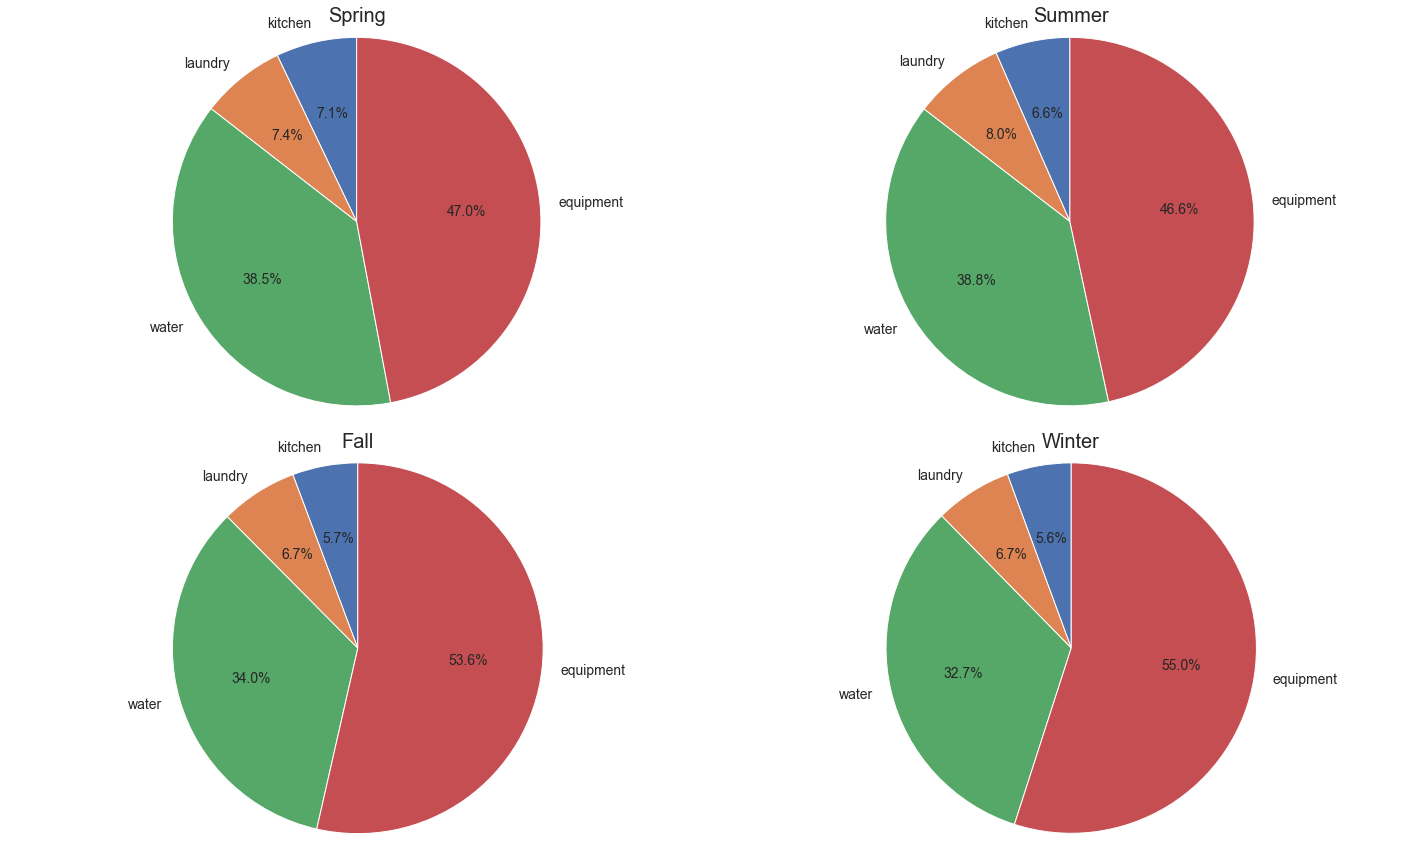

In [9]:
# equipamente data
data_equip = master.copy(deep=True)
data_equip['season'] = data_equip.apply(get_season, axis=1)
data_equip.reset_index(inplace=True)

#data_equip['year'] = data_equip['datetime'].apply(lambda item: item.year)

data_equip = data_equip.groupby(by=['season'], as_index=False).agg({
    'kitchen_active_energy'         : 'mean',
    'laundry_active_energy'         : 'mean',
    'water_heater_ac_active_energy' : 'mean',
    'equipment_active_energy'       : 'mean'
})

data_equip.rename(columns = {
    'kitchen_active_energy'         : 'kitchen',
    'laundry_active_energy'         : 'laundry',
    'water_heater_ac_active_energy' : 'water',
    'equipment_active_energy'       : 'equipment'
},inplace=True)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,12))

cond = data_equip['season'] == 'spring'
axes[0][0].pie(x=data_equip[cond][data_equip.columns[1:]], labels=data_equip.columns[1:],autopct='%1.1f%%',shadow=False, startangle=90, textprops={'fontsize': 14})
axes[0][0].set_title('Spring', fontsize=20)
axes[0][0].axis('equal')

cond = data_equip['season'] == 'summer'
axes[0][1].pie(x=data_equip[cond][data_equip.columns[1:]], labels=data_equip.columns[1:],autopct='%1.1f%%',shadow=False, startangle=90, textprops={'fontsize': 14})
axes[0][1].set_title('Summer', fontsize=20)
axes[0][1].axis('equal')

cond = data_equip['season'] == 'fall'
axes[1][0].pie(x=data_equip[cond][data_equip.columns[1:]], labels=data_equip.columns[1:],autopct='%1.1f%%',shadow=False, startangle=90, textprops={'fontsize': 14})
axes[1][0].set_title('Fall', fontsize=20)
axes[1][0].axis('equal')

cond = data_equip['season'] == 'winter'
axes[1][1].pie(x=data_equip[cond][data_equip.columns[1:]], labels=data_equip.columns[1:],autopct='%1.1f%%',shadow=False, startangle=90, textprops={'fontsize': 14})
axes[1][1].set_title('Winter', fontsize=20)
axes[1][1].axis('equal')


plt.tight_layout()

#### Time Series Decomposition
______

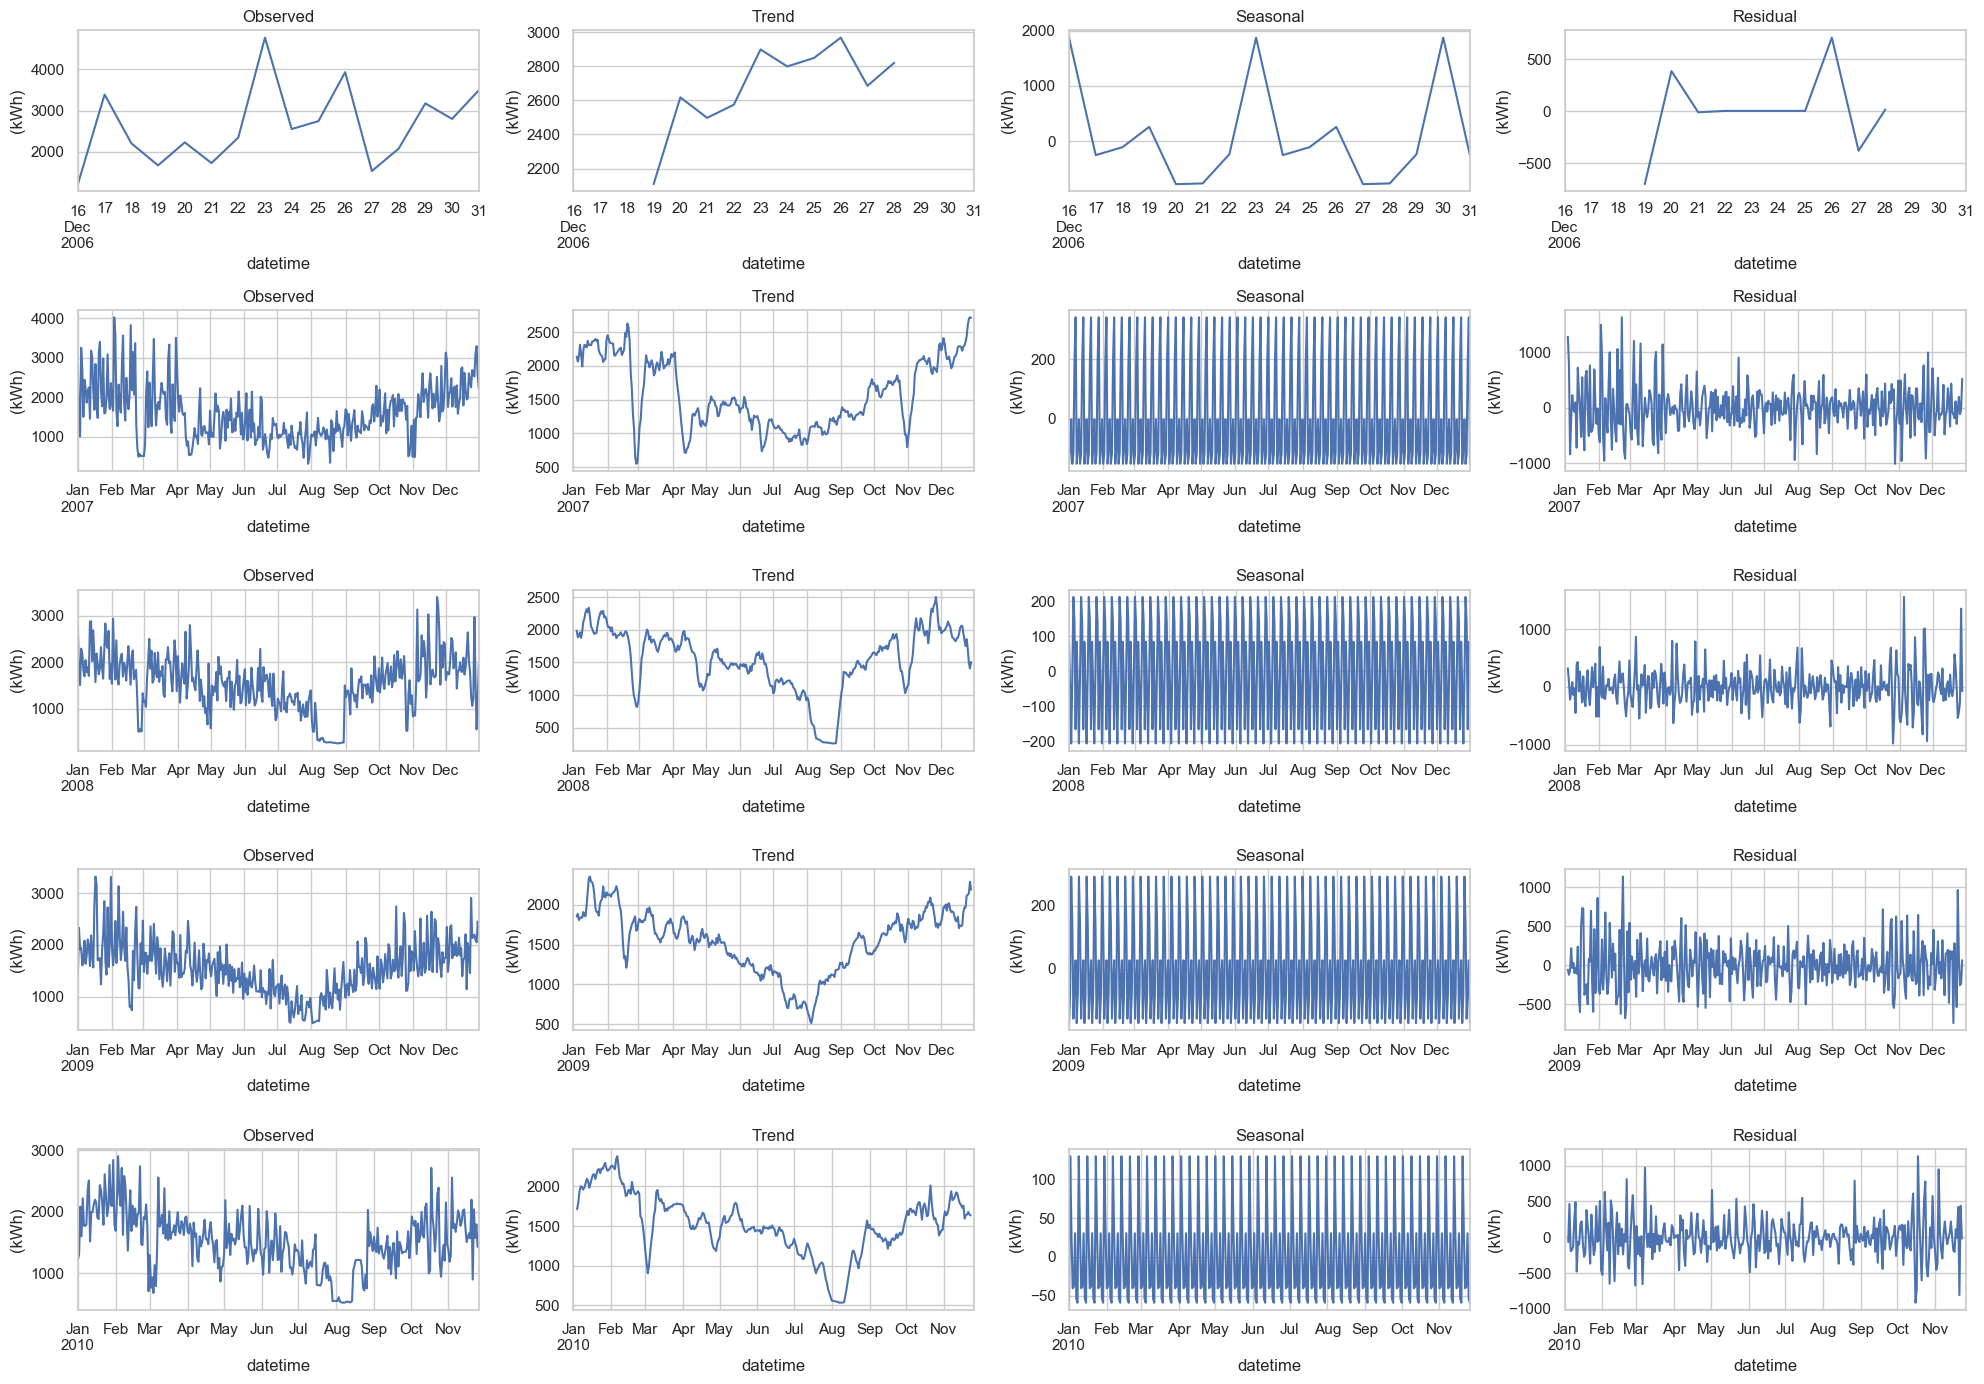

In [10]:
data_ts = master.copy(deep=True)
data_ts.reset_index(inplace=True)
data_ts['year'] = data_ts['datetime'].apply(lambda item: item.year)
data_ts.set_index('datetime',inplace=True)

#rcParams['figure.figsize'] = 9,4
#rcParams['figure.dpi'] = 100

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20,14), dpi=100)
line = 0

for year in range(2006, 2011):
    cond = data_ts['year'] == year
    result = seasonal_decompose(x=data_ts[cond]['Global_active_power'], model='additive')
    
    index = year - 2006
    axes[index][0] = result.observed.plot(ax=axes[index][0])
    axes[index][0].set_ylabel('(kWh)')
    axes[index][0].set_title('Observed')

    axes[index][1] = result.trend.plot(ax=axes[index][1])
    axes[index][1].set_ylabel('(kWh)')
    axes[index][1].set_title('Trend')

    axes[index][2] = result.seasonal.plot(ax=axes[index][2])
    axes[index][2].set_ylabel('(kWh)')
    axes[index][2].set_title('Seasonal')

    axes[index][2] = result.resid.plot(ax=axes[index][3])
    axes[index][2].set_ylabel('(kWh)')
    axes[index][2].set_title('Residual')
    
    

plt.tight_layout()

#### Correlations accross features
______

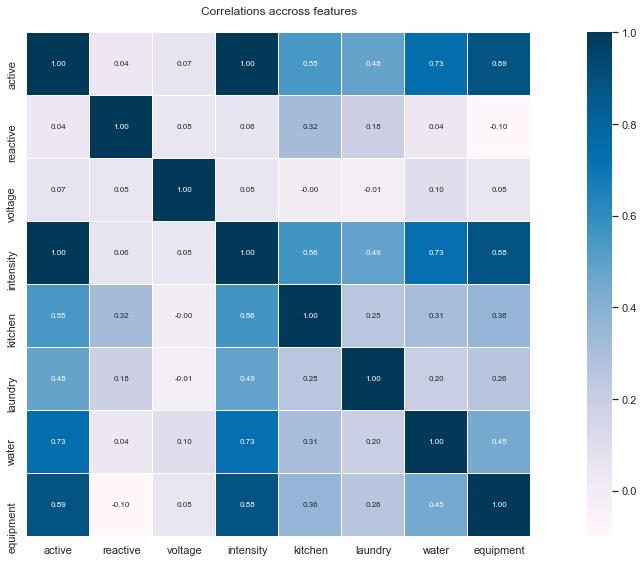

In [20]:
data_corr = master.copy(deep=True)

data_corr.rename(columns = {
    'Global_active_power'           : 'active',
    'Global_reactive_power'         : 'reactive',
    'Voltage'                       : 'voltage',
    'Global_intensity'              : 'intensity',
    'kitchen_active_energy'         : 'kitchen',
    'laundry_active_energy'         : 'laundry',
    'water_heater_ac_active_energy' : 'water',
    'equipment_active_energy'       : 'equipment'
},inplace=True)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,8))

# https://matplotlib.org/tutorials/colors/colormaps.html
sns.heatmap(data_corr.corr(), annot=True, cmap='PuBu', linewidths=0.2, ax=axes,fmt='.2f', annot_kws={"size": 8}, square=True)
axes.set_title('Correlations accross features\n')

plt.tight_layout()

In [108]:
#data_m['EWMA-12'] = data_m.ewm(span=12).mean()

#data_m

data_m = master.resample('M').sum()
data_m['EWMA-12'] = data_m['Global_active_power'].ewm(span=12).mean()
data_m[['Global_active_power', 'EWMA-12']]

,Global_active_power,EWMA-12
datetime,,
2006-12-31,41826.752,41826.752000
2007-01-31,69014.872,56553.650333
2007-02-28,56493.764,56530.276684
2007-03-31,58864.472,57267.090924
2007-04-30,37780.074,51972.538072
2007-05-31,44008.872,50036.948249
2007-06-30,35763.258,46851.824210
2007-07-31,29830.434,43299.722426
2007-08-31,34100.794,41479.846966


#### Electrical equipment energy consumption 
____

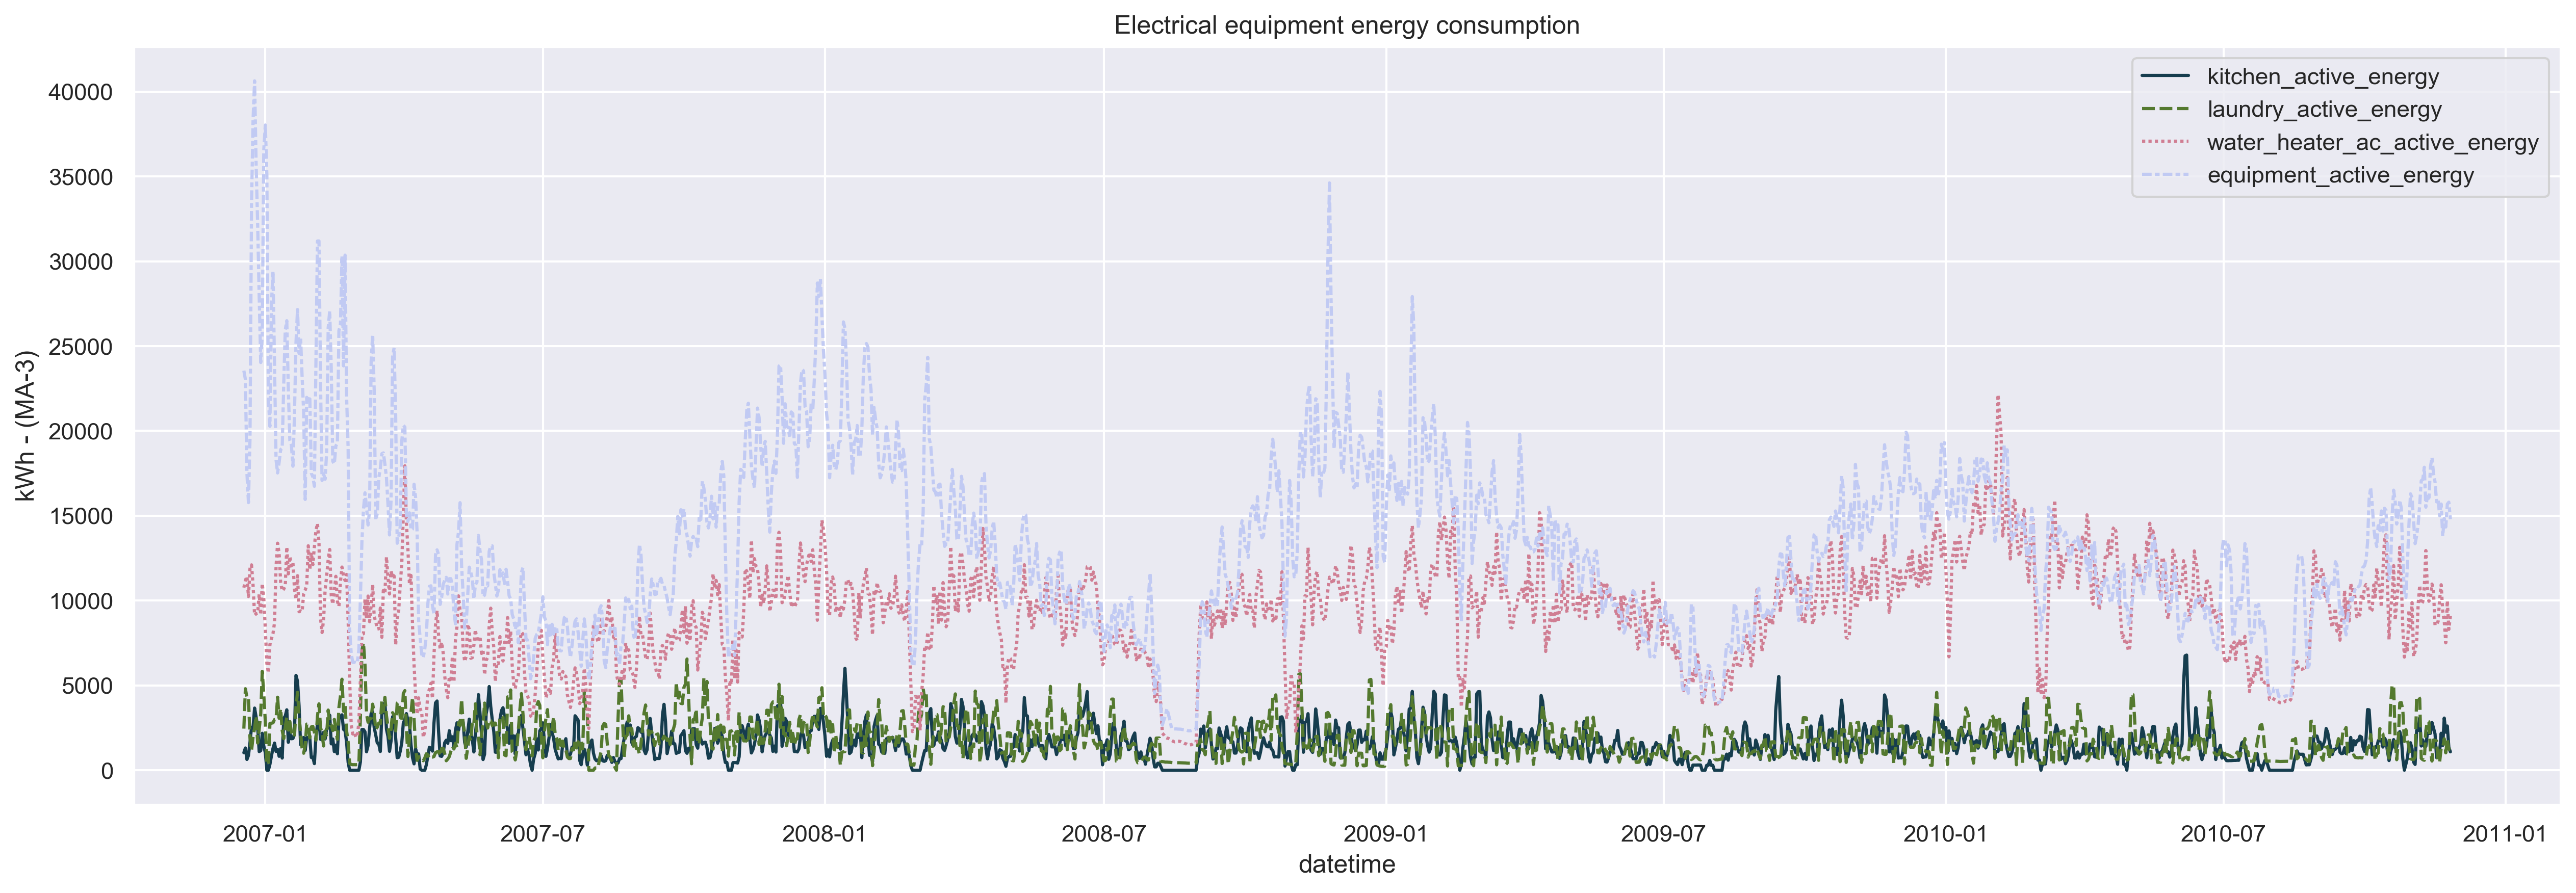

In [430]:
columns = ['kitchen_active_energy', 'laundry_active_energy', 'water_heater_ac_active_energy', 'equipment_active_energy']

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(17,6), dpi=300)
sns.lineplot(data=master[columns].rolling(3).mean(), palette='cubehelix',ax=axes)

axes.set_title('Electrical equipment energy consumption')
axes.set_ylabel('kWh - (MA-3)')

plt.tight_layout()


In [470]:
# equipamente data
data_equip = master.copy(deep=True)
data_equip['season'] = data_equip.apply(get_season, axis=1)
data_equip.reset_index(inplace=True)

#data_equip['year'] = data_equip['datetime'].apply(lambda item: item.year)

data_equip = data_equip.groupby(by=['season'], as_index=False).agg({
    'kitchen_active_energy'         : 'mean',
    'laundry_active_energy'         : 'mean',
    'water_heater_ac_active_energy' : 'mean',
    'equipment_active_energy'       : 'mean'
})

data_equip.rename(columns = {
    'kitchen_active_energy'         : 'kitchen',
    'laundry_active_energy'         : 'laundry',
    'water_heater_ac_active_energy' : 'water',
    'equipment_active_energy'       : 'equipment'
},inplace=True)

data_equip

,season,kitchen,laundry,water,equipment
0,fall,1671.828986,1977.028986,9978.617391,15713.448213
1,spring,1780.638587,1860.524457,9659.277174,11813.744844
2,summer,1151.807065,1397.945652,6809.298913,8175.874462
3,winter,1842.667590,2211.188366,10746.617729,18060.765748


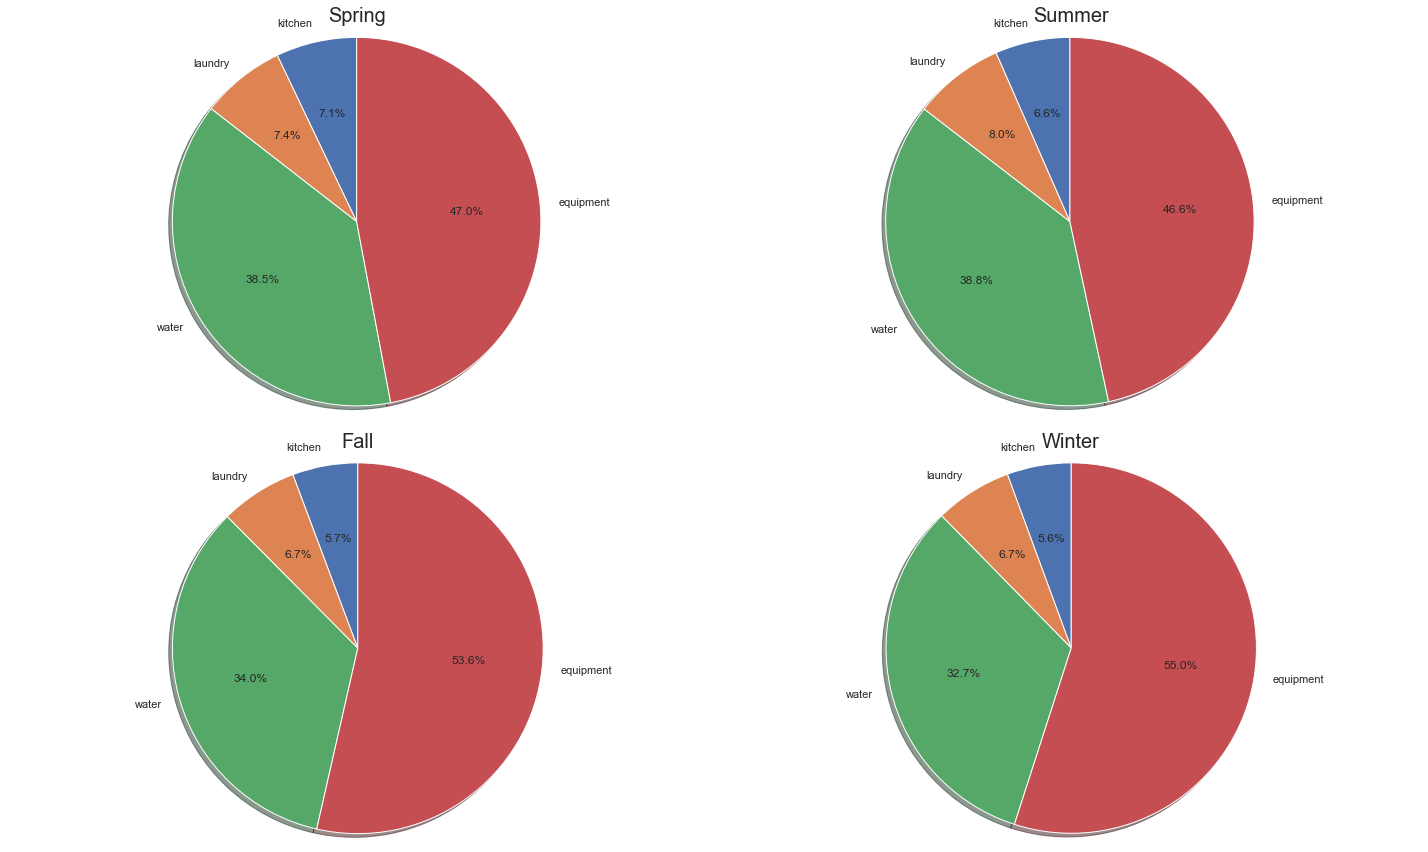

In [517]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,12))

cond = data_equip['season'] == 'spring'
axes[0][0].pie(x=data_equip[cond][data_equip.columns[1:]], labels=data_equip.columns[1:],autopct='%1.1f%%',shadow=True, startangle=90)
axes[0][0].set_title('Spring', fontsize=20)
axes[0][0].axis('equal')

cond = data_equip['season'] == 'summer'
axes[0][1].pie(x=data_equip[cond][data_equip.columns[1:]], labels=data_equip.columns[1:],autopct='%1.1f%%',shadow=True, startangle=90)
axes[0][1].set_title('Summer', fontsize=20)
axes[0][1].axis('equal')

cond = data_equip['season'] == 'fall'
axes[1][0].pie(x=data_equip[cond][data_equip.columns[1:]], labels=data_equip.columns[1:],autopct='%1.1f%%',shadow=True, startangle=90)
axes[1][0].set_title('Fall', fontsize=20)
axes[1][0].axis('equal')

cond = data_equip['season'] == 'winter'
axes[1][1].pie(x=data_equip[cond][data_equip.columns[1:]], labels=data_equip.columns[1:],autopct='%1.1f%%',shadow=True, startangle=90)
axes[1][1].set_title('Winter', fontsize=20)
axes[1][1].axis('equal')


plt.tight_layout()